In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Batch Normalization
使深度网络更容易训练的一种方法是使用更复杂的优化程序，如SGD+动量、RMSProp或Adam。另一种策略是改变网络的架构，使其更易于训练。沿着这些思路的一个想法是批量规范化，由[1]在2015年提出。

为了理解批量归一化的目标，重要的是首先要认识到，机器学习方法往往在输入数据由零均值和单位方差的不相关特征组成时表现更好。当训练神经网络时，我们可以在将数据输入网络之前对其进行预处理，以明确地解相关其特征。这将确保网络的第一层看到遵循良好分布的数据。然而，即使我们对输入数据进行预处理，网络较深层的激活也可能不再是去相关的，也不再具有零均值或单位方差，因为它们是从网络中较早的层输出的。更糟糕的是，在训练过程中，随着每层权重的更新，网络每层的特征分布将发生变化。

[1]的作者假设，深度神经网络内部特征分布的变化可能会使训练深度网络变得更加困难。为了克服这个问题，他们建议在网络层中插入规范化批处理的层。在训练时，这样的层使用数据的小批量来估计每个特征的平均值和标准差。然后使用这些估计的平均值和标准偏差来集中和归一化mini-batch的特征。这些平均值和标准偏差的运行平均值在训练期间保持，在测试时，这些运行平均值用于集中和归一化特征。
这种归一化策略可能会降低网络的代表能力，因为有时某些层的特征不是零均值或单位方差可能是最优的。为此，批量归一化层包括每个特征维度的可学习的偏移和缩放参数。

[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

In [1]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def print_mean_std(x,axis=0):
    print(f"  means: {x.mean(axis=axis)}")
    print(f"  stds:  {x.std(axis=axis)}\n")

=========== You can safely ignore the message below if you are NOT working on ConvolutionalNetworks.ipynb ===========
	You will need to compile a Cython extension for a portion of this assignment.
	The instructions to do this will be given in a section of the notebook below.


In [2]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


# Batch Normalization: Forward Pass
在文件`cs231n/layers.py`中，在函数`batchnorm_forward`中实现批量规范化前向传递。完成后，请运行以下操作来测试您的实现。
参考[1]中链接到上面的论文可能会有所帮助！

In [4]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization   

# Simulate the forward pass for a two-layer network.
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print_mean_std(a,axis=0)

gamma = np.ones((D3,))
beta = np.zeros((D3,))

# Means should be close to zero and stds close to one.
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])

# Now means should be close to beta and stds close to gamma.
print('After batch normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

Before batch normalization:
  means: [ -2.3814598  -13.18038246   1.91780462]
  stds:  [27.18502186 34.21455511 37.68611762]

After batch normalization (gamma=1, beta=0)
  means: [3.10862447e-17 6.82787160e-17 2.62984079e-17]
  stds:  [0.99999999 1.         1.        ]

After batch normalization (gamma= [1. 2. 3.] , beta= [11. 12. 13.] )
  means: [11. 12. 13.]
  stds:  [0.99999999 1.99999999 2.99999999]



In [6]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)

for t in range(50):
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print_mean_std(a_norm,axis=0)

After batch normalization (test-time):
  means: [-0.03927354 -0.04349152 -0.10452688]
  stds:  [1.01531428 1.01238373 0.97819988]



# Batch Normalization: Backward Pass
Now implement the backward pass for batch normalization in the function `batchnorm_backward`.

To derive the backward pass you should write out the computation graph for batch normalization and backprop through each of the intermediate nodes. Some intermediates may have multiple outgoing branches; make sure to sum gradients across these branches in the backward pass.

Once you have finished, run the following to numerically check your backward pass.

In [7]:
# Gradient check batchnorm backward pass.
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)

# You should expect to see relative errors between 1e-13 and 1e-8.
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.6674604875341426e-09
dgamma error:  7.417225040694815e-13
dbeta error:  2.379446949959628e-12


# Batch Normalization: Alternative Backward Pass
在课堂上，我们讨论了S形后向传递的两种不同实现。一种策略是写出一个由简单运算和所有中间值的反向运算组成的计算图。另一种策略是在纸上计算导数。例如，通过简化纸上的梯度，可以推导出一个非常简单的s形函数后向传递公式。

令人惊讶的是，事实证明，您也可以对批处理规范化反向传递进行类似的简化！ 

In the forward pass, given a set of inputs $X=\begin{bmatrix}x_1\\x_2\\...\\x_N\end{bmatrix}$, 

we first calculate the mean $\mu$ and variance $v$.
With $\mu$ and $v$ calculated, we can calculate the standard deviation $\sigma$  and normalized data $Y$.
The equations and graph illustration below describe the computation ($y_i$ is the i-th element of the vector $Y$).

\begin{align}
& \mu=\frac{1}{N}\sum_{k=1}^N x_k  &  v=\frac{1}{N}\sum_{k=1}^N (x_k-\mu)^2 \\
& \sigma=\sqrt{v+\epsilon}         &  y_i=\frac{x_i-\mu}{\sigma}
\end{align}

<img src="https://raw.githubusercontent.com/cs231n/cs231n.github.io/master/assets/a2/batchnorm_graph.png">

The meat of our problem during backpropagation is to compute $\frac{\partial L}{\partial X}$, given the upstream gradient we receive, $\frac{\partial L}{\partial Y}.$ To do this, recall the chain rule in calculus gives us $\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \cdot \frac{\partial Y}{\partial X}$.

The unknown/hard part is $\frac{\partial Y}{\partial X}$. We can find this by first deriving step-by-step our local gradients at 
$\frac{\partial v}{\partial X}$, $\frac{\partial \mu}{\partial X}$,
$\frac{\partial \sigma}{\partial v}$, 
$\frac{\partial Y}{\partial \sigma}$, and $\frac{\partial Y}{\partial \mu}$,
and then use the chain rule to compose these gradients (which appear in the form of vectors!) appropriately to compute $\frac{\partial Y}{\partial X}$.

If it's challenging to directly reason about the gradients over $X$ and $Y$ which require matrix multiplication, try reasoning about the gradients in terms of individual elements $x_i$ and $y_i$ first: in that case, you will need to come up with the derivations for $\frac{\partial L}{\partial x_i}$, by relying on the Chain Rule to first calculate the intermediate $\frac{\partial \mu}{\partial x_i}, \frac{\partial v}{\partial x_i}, \frac{\partial \sigma}{\partial x_i},$ then assemble these pieces to calculate $\frac{\partial y_i}{\partial x_i}$. 

You should make sure each of the intermediary gradient derivations are all as simplified as possible, for ease of implementation. 

After doing so, implement the simplified batch normalization backward pass in the function `batchnorm_backward_alt` and compare the two implementations by running the following. Your two implementations should compute nearly identical results, but the alternative implementation should be a bit faster.

In [8]:
np.random.seed(231)
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = batchnorm_forward(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = time.time()

print('dx difference: ', rel_error(dx1, dx2))
print('dgamma difference: ', rel_error(dgamma1, dgamma2))
print('dbeta difference: ', rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

dx difference:  1.3761230828705064e-12
dgamma difference:  1.3234426801152552e-14
dbeta difference:  0.0
speedup: 1.91x


# Fully Connected Networks with Batch Normalization
Now that you have a working implementation for batch normalization, go back to your `FullyConnectedNet` in the file `cs231n/classifiers/fc_net.py`. Modify your implementation to add batch normalization.

Concretely, when the `normalization` flag is set to `"batchnorm"` in the constructor, you should insert a batch normalization layer before each ReLU nonlinearity. The outputs from the last layer of the network should not be normalized. Once you are done, run the following to gradient-check your implementation.

**Hint:** You might find it useful to define an additional helper layer similar to those in the file `cs231n/layer_utils.py`.

In [13]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

# You should expect losses between 1e-4~1e-10 for W, 
# losses between 1e-08~1e-10 for b,
# and losses between 1e-08~1e-09 for beta and gammas.
for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            normalization='batchnorm')

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  if reg == 0: print()

Running check with reg =  0
Initial loss:  2.2611955101340957
W1 relative error: 1.10e-04
W2 relative error: 5.65e-06
W3 relative error: 4.14e-10
b1 relative error: 1.05e-08
b2 relative error: 2.72e-07
b3 relative error: 1.02e-10
beta1 relative error: 7.85e-09
beta2 relative error: 1.89e-09
gamma1 relative error: 7.47e-09
gamma2 relative error: 3.35e-09

Running check with reg =  3.14
Initial loss:  6.996533220108303
W1 relative error: 1.98e-06
W2 relative error: 2.29e-06
W3 relative error: 1.11e-08
b1 relative error: 1.60e-08
b2 relative error: 2.19e-09
b3 relative error: 2.10e-10
beta1 relative error: 6.65e-09
beta2 relative error: 4.23e-09
gamma1 relative error: 5.94e-09
gamma2 relative error: 4.14e-09


# Batch Normalization for Deep Networks
Run the following to train a six-layer network on a subset of 1000 training examples both with and without batch normalization.

In [14]:
np.random.seed(231)

# Try training a very deep net with batchnorm.
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)

print('Solver with batch norm:')
bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True,print_every=20)
bn_solver.train()

print('\nSolver without batch norm:')
solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

Solver with batch norm:
(Iteration 1 / 200) loss: 2.340974
(Epoch 0 / 10) train acc: 0.139000; val_acc: 0.135000
(Epoch 1 / 10) train acc: 0.310000; val_acc: 0.262000
(Iteration 21 / 200) loss: 1.999443
(Epoch 2 / 10) train acc: 0.414000; val_acc: 0.308000
(Iteration 41 / 200) loss: 2.052620
(Epoch 3 / 10) train acc: 0.463000; val_acc: 0.296000
(Iteration 61 / 200) loss: 1.810844
(Epoch 4 / 10) train acc: 0.502000; val_acc: 0.301000
(Iteration 81 / 200) loss: 1.331292
(Epoch 5 / 10) train acc: 0.567000; val_acc: 0.313000
(Iteration 101 / 200) loss: 1.385209
(Epoch 6 / 10) train acc: 0.599000; val_acc: 0.321000
(Iteration 121 / 200) loss: 1.231006
(Epoch 7 / 10) train acc: 0.662000; val_acc: 0.331000
(Iteration 141 / 200) loss: 1.193789
(Epoch 8 / 10) train acc: 0.700000; val_acc: 0.351000
(Iteration 161 / 200) loss: 0.769956
(Epoch 9 / 10) train acc: 0.732000; val_acc: 0.325000
(Iteration 181 / 200) loss: 1.096397
(Epoch 10 / 10) train acc: 0.776000; val_acc: 0.333000

Solver without b

Run the following to visualize the results from two networks trained above. You should find that using batch normalization helps the network to converge much faster.

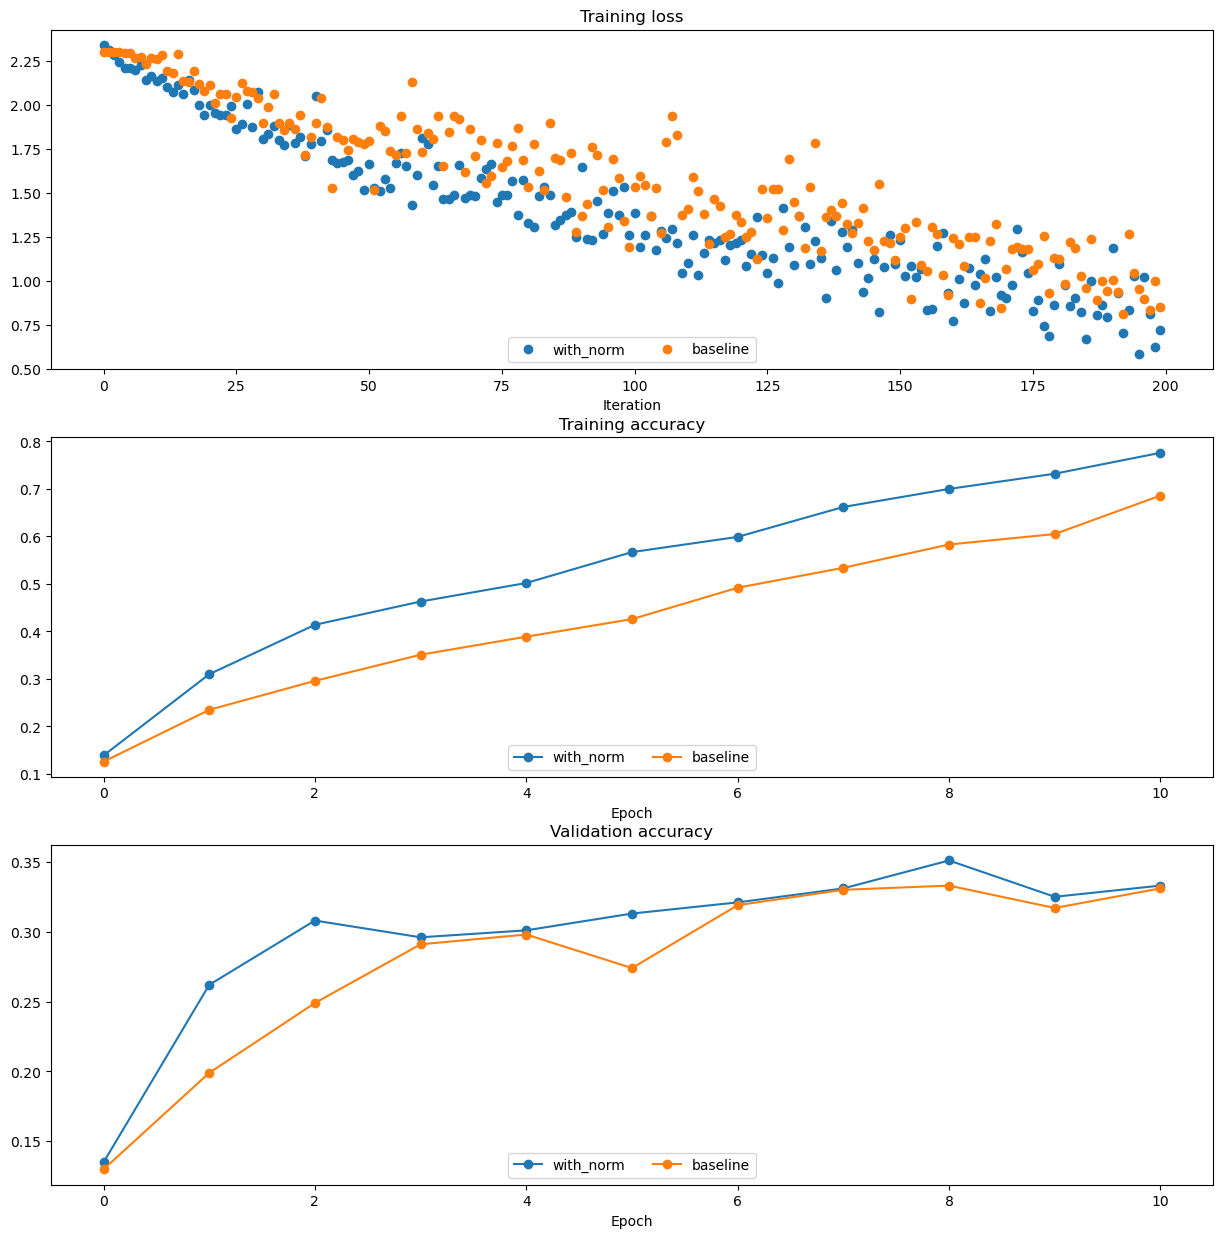

In [15]:
def plot_training_history(title, label, baseline, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plot = plot_fn(baseline)
    num_bn = len(bn_plots)
    for i in range(num_bn):
        label='with_norm'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    label='baseline'
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1) 

    
plt.subplot(3, 1, 1)
plot_training_history('Training loss','Iteration', solver, [bn_solver], \
                      lambda x: x.loss_history, bl_marker='o', bn_marker='o')
plt.subplot(3, 1, 2)
plot_training_history('Training accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history('Validation accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Batch Normalization and Initialization
我们现在将进行一个小实验来研究批量归一化和权重初始化的相互作用。

第一个单元将使用不同的权重初始化尺度来训练具有和不具有批量归一化的八层网络。第二层将绘制训练准确性、验证集准确性和训练损失作为权重初始化量表的函数。

In [17]:
np.random.seed(231)

# Try training a very deep net with batchnorm.
hidden_dims = [50, 50, 50, 50, 50, 50, 50]
num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers_ws = {}
solvers_ws = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
    print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
    bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)

    bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
    bn_solver.train()
    bn_solvers_ws[weight_scale] = bn_solver

    solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
    solver.train()
    solvers_ws[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


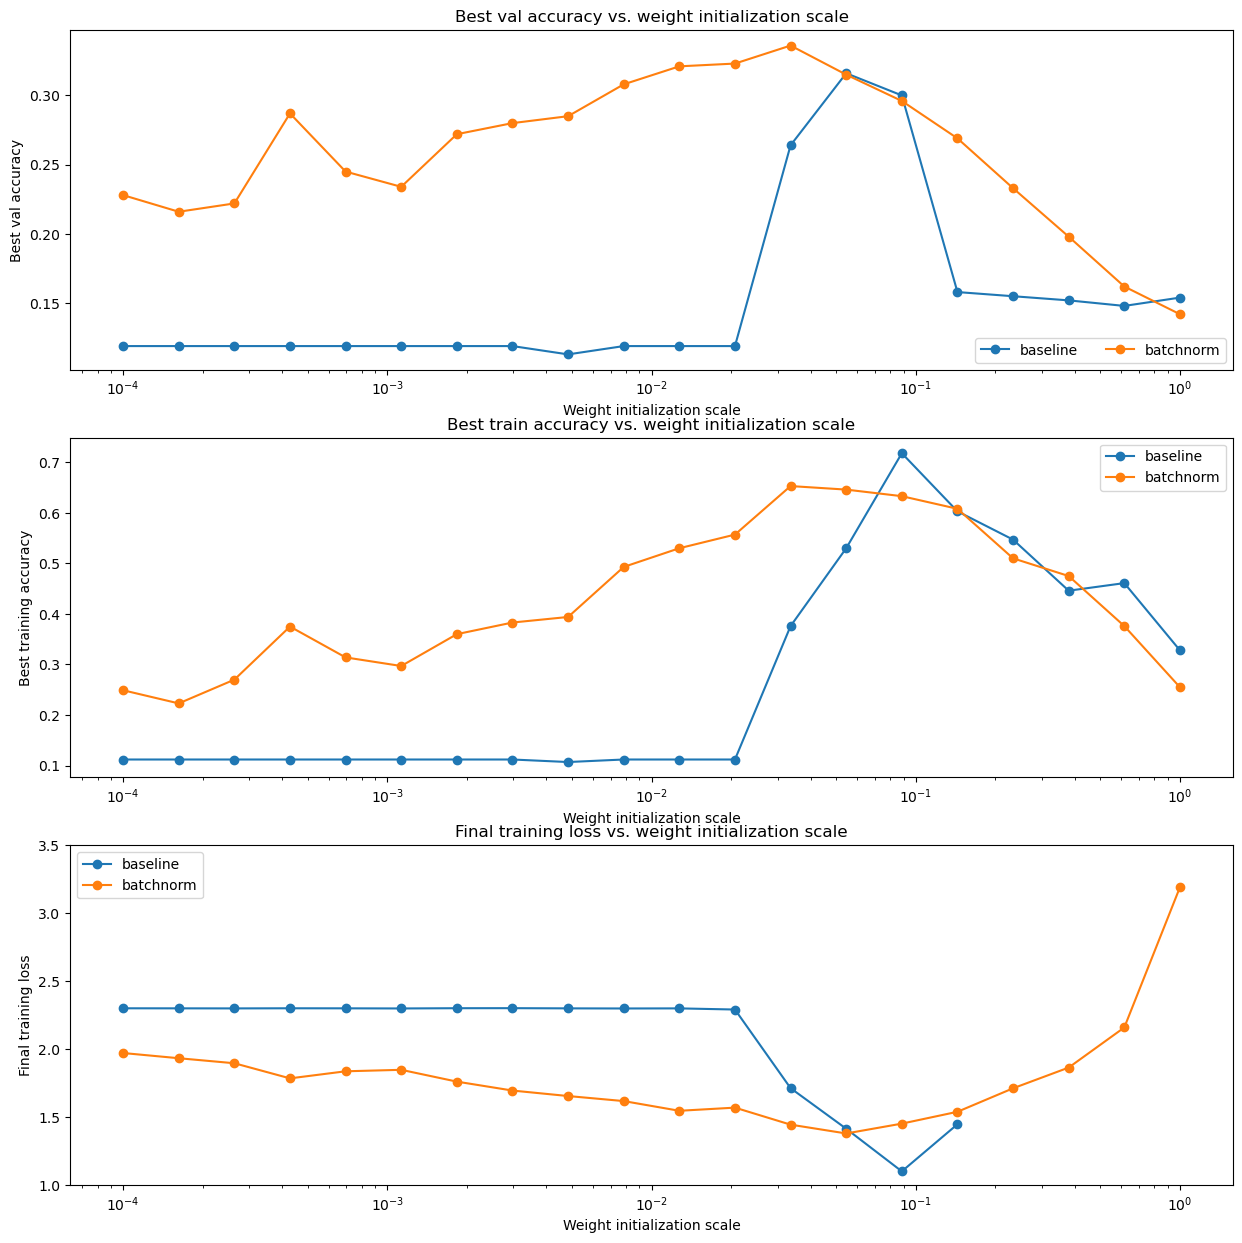

In [18]:
# Plot results of weight scale experiment.
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
  best_train_accs.append(max(solvers_ws[ws].train_acc_history))
  bn_best_train_accs.append(max(bn_solvers_ws[ws].train_acc_history))
  
  best_val_accs.append(max(solvers_ws[ws].val_acc_history))
  bn_best_val_accs.append(max(bn_solvers_ws[ws].val_acc_history))
  
  final_train_loss.append(np.mean(solvers_ws[ws].loss_history[-100:]))
  bn_final_train_loss.append(np.mean(bn_solvers_ws[ws].loss_history[-100:]))
  
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs. weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs. weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs. weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()
plt.gca().set_ylim(1.0, 3.5)

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 1:
Describe the results of this experiment. How does the weight initialization scale affect models with/without batch normalization differently, and why?

## Answer:
该实验的结果可能会显示，权重初始化的尺度对于使用批归一化（batch normalization）和不使用批归一化的模型产生不同的影响。

对于没有使用批归一化的模型而言，权重初始化的尺度可能会显著影响训练过程和模型的性能。如果权重初始化过小，模型可能难以学习有意义的表示，导致收敛缓慢、梯度消失（vanishing gradients）以及整体性能不佳。另一方面，如果权重初始化过大，模型可能会出现梯度爆炸（exploding gradients），导致训练过程不稳定并影响收敛。

与此不同，对于使用批归一化的模型而言，权重初始化尺度的影响可能会在一定程度上减小。批归一化在训练过程中对层的输入进行了归一化，减少了模型对权重尺度的依赖性，从而有助于减小模型对初始权重尺度的敏感性。

具体而言，批归一化通过在训练过程中对层的输入进行缩放和偏移来进行归一化。这个归一化步骤有助于稳定训练过程，减少内部协变量偏移（internal covariate shift），即训练过程中输入到层的分布的变化。因此，批归一化可以使训练过程对不同的权重初始化尺度更加鲁棒，因为它可以通过对每一层的输入进行缩放和偏移来适应权重尺度的变化。

然而，对于使用批归一化的模型，仍然需要选择合适的权重初始化尺度。过小或过大的权重初始化尺度仍然可能影响模型的收敛速度和最终性能，尽管相较于没有批归一化的模型，影响可能较小。

总而言之，权重初始化尺度对于使用和不使用批归一化的模型可能会产生不同的影响。批归一化可以帮助减小模型对权重初始化尺度的敏感性，但仍然需要选择合适的初始化尺度以实现神经网络的最佳训练和性能。通过尝试不同的权重初始化尺度，可以找到适合特定模型架构和数据集的最佳方法。








# Batch Normalization and Batch Size
我们现在将进行一个小实验来研究批量标准化和批量大小的相互作用。

第一个单元将使用不同的批量大小训练具有和不具有批量归一化的6层网络。第二层将绘制训练准确性和验证集准确性随时间的变化

In [21]:
def run_batchsize_experiments(normalization_mode):
    np.random.seed(231)
    
    # Try training a very deep net with batchnorm.
    hidden_dims = [100, 100, 100, 100, 100]
    num_train = 1000
    small_data = {
      'X_train': data['X_train'][:num_train],
      'y_train': data['y_train'][:num_train],
      'X_val': data['X_val'],
      'y_val': data['y_val'],
    }
    n_epochs=10
    weight_scale = 2e-2
    batch_sizes = [5,10,50]
    lr = 10**(-3.5)
    solver_bsize = batch_sizes[0]

    print('No normalization: batch size = ',solver_bsize)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)
    solver = Solver(model, small_data,
                    num_epochs=n_epochs, batch_size=solver_bsize,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },
                    verbose=False)
    solver.train()
    
    bn_solvers = []
    for i in range(len(batch_sizes)):
        b_size=batch_sizes[i]
        print('Normalization: batch size = ',b_size)
        bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=normalization_mode)
        bn_solver = Solver(bn_model, small_data,
                        num_epochs=n_epochs, batch_size=b_size,
                        update_rule='adam',
                        optim_config={
                          'learning_rate': lr,
                        },
                        verbose=False)
        bn_solver.train()
        bn_solvers.append(bn_solver)
        
    return bn_solvers, solver, batch_sizes

batch_sizes = [5,10,50]
bn_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('batchnorm')

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


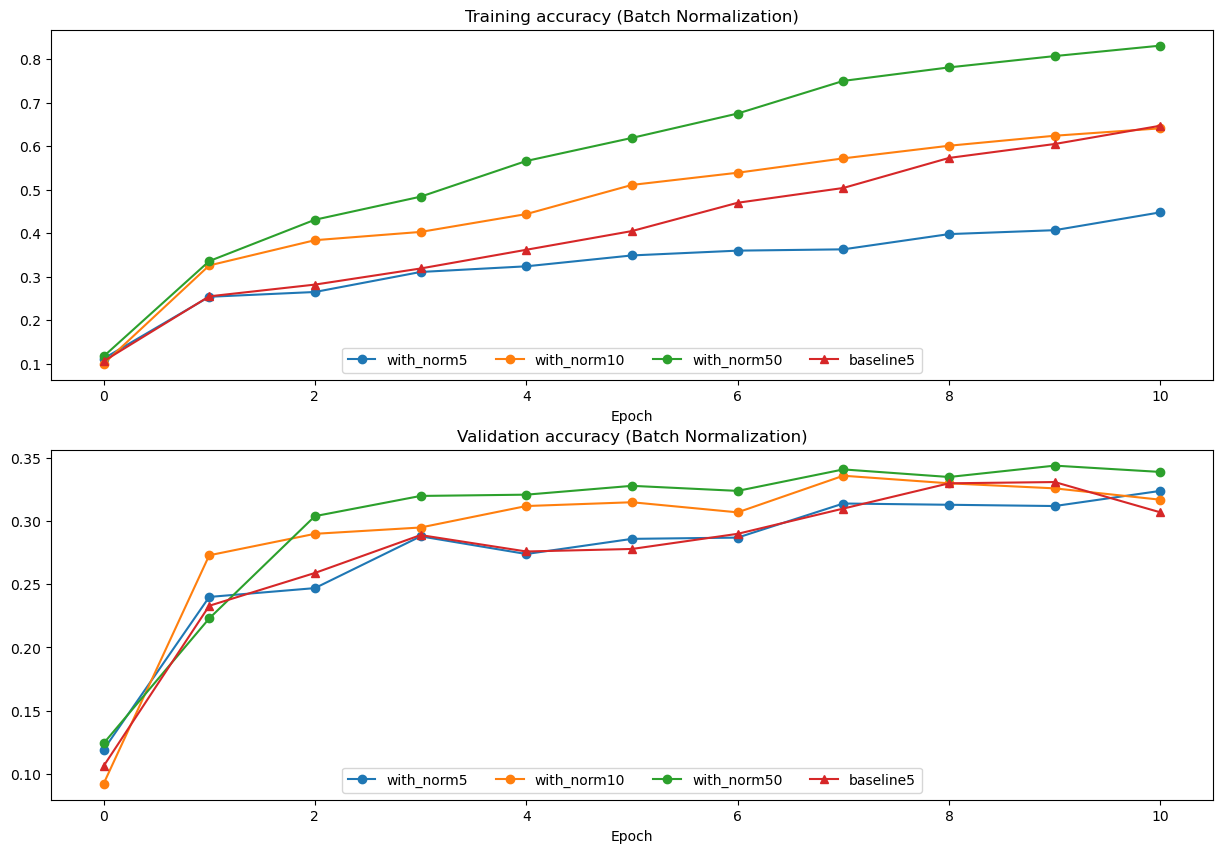

In [22]:
plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

## Inline Question 2:
Describe the results of this experiment. What does this imply about the relationship between batch normalization and batch size? Why is this relationship observed?

## Answer:
【使用了批量归一化的模型的性能明显相对于baseline的不使用归一化的模型有明显的提高，训练集和验证集的正确率相对baseline有显著的提升】

在使用批归一化时，模型的性能可能会随着不同的批量大小而变化。对于较小的批量大小，模型可能在估计的用于归一化的统计量中面临更多的噪声，这可能导致不稳定的归一化，并可能降低模型的性能。另一方面，对于较大的批量大小，用于归一化的估计统计量可能更加稳定，从而导致更好的性能。

批归一化与批量大小之间的关联可以通过批归一化的工作方式来解释。批归一化在训练期间计算在一个小批量样本中层输入的均值和方差，并使用这些统计量对输入进行归一化，通过缩放和平移来调整它们。当批量大小较小时，估计的统计量可能无法准确地代表输入的真实分布，从而导致不太有效的归一化。相反，对于较大的批量大小，估计的统计量很可能更能代表真实分布，从而导致更好的归一化效果。

批量大小还会影响批归一化的正则化效果。对于较大的批量大小，批归一化的正则化效果可能会更强，因为较大批量大小下的估计统计量可以减少模型梯度中的噪声和波动，从而实现更稳定的训练过程。

因此，在训练神经网络时，需要考虑批归一化与批量大小之间的关系。较小的批量大小可能需要仔细调整其他超参数，如学习率和权重衰减，以确保稳定的训练和良好的性能。另一方面，较大的批量大小可能会导致更稳定的训练和更好的性能，但也可能对内存使用和计算效率产生影响。在特定模型和数据集中，确定最佳的批量大小可能需要通过实验证明并仔细考虑不同因素之间的权衡。








# Layer Normalization
Batch normalization has proved to be effective in making networks easier to train, but the dependency on batch size makes it less useful in complex networks which have a cap on the input batch size due to hardware limitations. 

Several alternatives to batch normalization have been proposed to mitigate this problem; one such technique is Layer Normalization [2]. Instead of normalizing over the batch, we normalize over the features. In other words, when using Layer Normalization, each feature vector corresponding to a single datapoint is normalized based on the sum of all terms within that feature vector.

[2] [Ba, Jimmy Lei, Jamie Ryan Kiros, and Geoffrey E. Hinton. "Layer Normalization." stat 1050 (2016): 21.](https://arxiv.org/pdf/1607.06450.pdf)

## Inline Question 3:
Which of these data preprocessing steps is analogous to batch normalization, and which is analogous to layer normalization?

1. 缩放数据集中的每个图像，使图像中每行像素的RGB通道总计为1
2. 缩放数据集中的每个图像，使图像中所有像素的RGB通道相加为1
3. 从数据集中的每个图像中减去数据集的平均图像
4. 根据给定的阈值将所有RGB值设置为0或1

## Answer:
批量归一化是不同训练数据之间对单个神经元的归一化；

层归一化是单个训练数据对某一层所有神经元之间的归一化（从数据集中的每个图像中减去数据集的平均图像）



# Layer Normalization: Implementation

Now you'll implement layer normalization. This step should be relatively straightforward, as conceptually the implementation is almost identical to that of batch normalization. One significant difference though is that for layer normalization, we do not keep track of the moving moments, and the testing phase is identical to the training phase, where the mean and variance are directly calculated per datapoint.

Here's what you need to do:

* In `cs231n/layers.py`, implement the forward pass for layer normalization in the function `layernorm_forward`. 

Run the cell below to check your results.
* In `cs231n/layers.py`, implement the backward pass for layer normalization in the function `layernorm_backward`. 

Run the second cell below to check your results.
* Modify `cs231n/classifiers/fc_net.py` to add layer normalization to the `FullyConnectedNet`. When the `normalization` flag is set to `"layernorm"` in the constructor, you should insert a layer normalization layer before each ReLU nonlinearity. 

Run the third cell below to run the batch size experiment on layer normalization.

In [ ]:
# Check the training-time forward pass by checking means and variances
# of features both before and after layer normalization.

# Simulate the forward pass for a two-layer network.
np.random.seed(231)
N, D1, D2, D3 =4, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before layer normalization:')
print_mean_std(a,axis=1)

gamma = np.ones(D3)
beta = np.zeros(D3)

# Means should be close to zero and stds close to one.
print('After layer normalization (gamma=1, beta=0)')
a_norm, _ = layernorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=1)

gamma = np.asarray([3.0,3.0,3.0])
beta = np.asarray([5.0,5.0,5.0])

# Now means should be close to beta and stds close to gamma.
print('After layer normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = layernorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=1)

In [ ]:
# Gradient check batchnorm backward pass.
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

ln_param = {}
fx = lambda x: layernorm_forward(x, gamma, beta, ln_param)[0]
fg = lambda a: layernorm_forward(x, a, beta, ln_param)[0]
fb = lambda b: layernorm_forward(x, gamma, b, ln_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = layernorm_forward(x, gamma, beta, ln_param)
dx, dgamma, dbeta = layernorm_backward(dout, cache)

# You should expect to see relative errors between 1e-12 and 1e-8.
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

# Layer Normalization and Batch Size

We will now run the previous batch size experiment with layer normalization instead of batch normalization. Compared to the previous experiment, you should see a markedly smaller influence of batch size on the training history!

In [ ]:
ln_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('layernorm')

plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Layer Normalization)','Epoch', solver_bsize, ln_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Layer Normalization)','Epoch', solver_bsize, ln_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

## Inline Question 4:
When is layer normalization likely to not work well, and why?

1. Using it in a very deep network
2. Having a very small dimension of features
3. Having a high regularization term


## Answer:
[FILL THIS IN]
